# **Decision Trees**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *

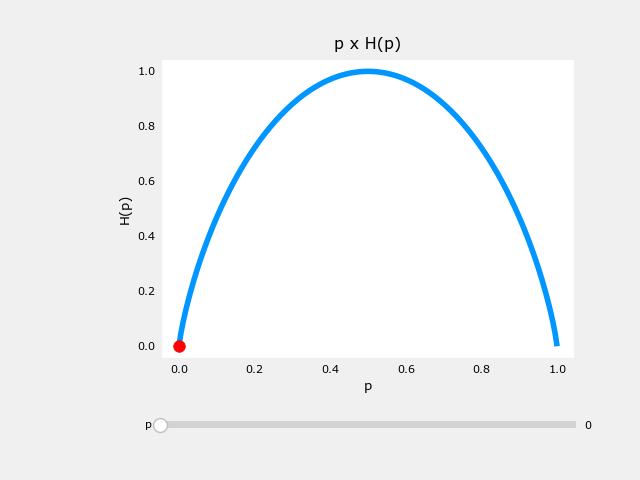

In [3]:
%matplotlib widget
_ = plot_entropy()

In [4]:
X_train = np.array([[1, 1, 1],
[0, 0, 1],
 [0, 1, 0],
 [1, 0, 1],
 [1, 1, 1],
 [1, 1, 0],
 [0, 0, 0],
 [1, 1, 0],
 [0, 1, 0],
 [0, 1, 0]])

y_train = np.array([1, 1, 0, 0, 1, 1, 0, 1, 0, 0])

In [5]:
# For instance, the first example
X_train[0]

array([1, 1, 1])

In [6]:
def entropy(p):
    if p == 0 or p == 1:
        return 0
    else:
        return -p * np.log2(p) - (1-p)*np.log2(1-p)
    
print(entropy(0.5))

1.0


In [7]:
def split_indices(X, index_feature):
    """Given a dataset and a index feature, return two lists for the two split nodes, the left node has the animals that have
    that feature = 1 and the right node those that have the feature = 0
    index feature = 0 => ear shape
    index feature = 1 => face shape
    index feature = 2 => whiskers
    """
    left_indices = []
    right_indices = []
    for i,x in enumerate(X):
        if x[index_feature] == 1:
            left_indices.append(i)
        else:
            right_indices.append(i)
    return left_indices, right_indices

In [8]:
split_indices(X_train, 0)

([0, 3, 4, 5, 7], [1, 2, 6, 8, 9])

In [9]:
def weighted_entropy(X, y, left_indices, right_indices):
    """
    This function takes the splitted dataset, the indices we chose to split and returns the weighted entropy.
    """
    w_left = len(left_indices)/len(X)
    w_right = len(right_indices)/len(X)
    p_left = sum(y[left_indices])/len(left_indices)
    p_right = sum(y[right_indices])/len(right_indices)

    weighted_entropy = w_left * entropy(p_left) + w_right * entropy(p_right)
    return weighted_entropy

In [10]:
left_indices, right_indices = split_indices(X_train, 0)
weighted_entropy(X_train, y_train, left_indices, right_indices)

0.7219280948873623

In [11]:
def information_gain(X, y, left_indices, right_indices):
    """
    Here, X has the elements in the node and y is theirs respectives classes
    """
    p_node = sum(y)/len(y)
    h_node = entropy(p_node)
    w_entropy = weighted_entropy(X, y, left_indices, right_indices)
    return h_node - w_entropy

In [12]:
information_gain(X_train, y_train, left_indices, right_indices)

0.2780719051126377

In [13]:
for i, feature_name in enumerate(['Ear Shape', 'Face Shape', 'Whiskers']):
    left_indices, right_indices = split_indices(X_train, i)
    i_gain = information_gain(X_train, y_train, left_indices, right_indices)
    print(f"Feature: {feature_name}, information gain if we split the root node using this feature: {i_gain:.2f}")

Feature: Ear Shape, information gain if we split the root node using this feature: 0.28
Feature: Face Shape, information gain if we split the root node using this feature: 0.03
Feature: Whiskers, information gain if we split the root node using this feature: 0.12


In [14]:
tree = []
build_tree_recursive(X_train, y_train, [0,1,2,3,4,5,6,7,8,9], "Root", max_depth=1, current_depth=0, tree=tree)
generate_tree_viz([0,1,2,3,4,5,6,7,8,9], y_train, tree)

 Depth 0, Root: Split on feature: 0
 - Left leaf node with indices [0, 3, 4, 5, 7]
 - Right leaf node with indices [1, 2, 6, 8, 9]


KeyboardInterrupt: 

 Depth 0, Root: Split on feature: 0
- Depth 1, Left: Split on feature: 1
  -- Left leaf node with indices [0, 4, 5, 7]
  -- Right leaf node with indices [3]
- Depth 1, Right: Split on feature: 2
  -- Left leaf node with indices [1]
  -- Right leaf node with indices [2, 6, 8, 9]


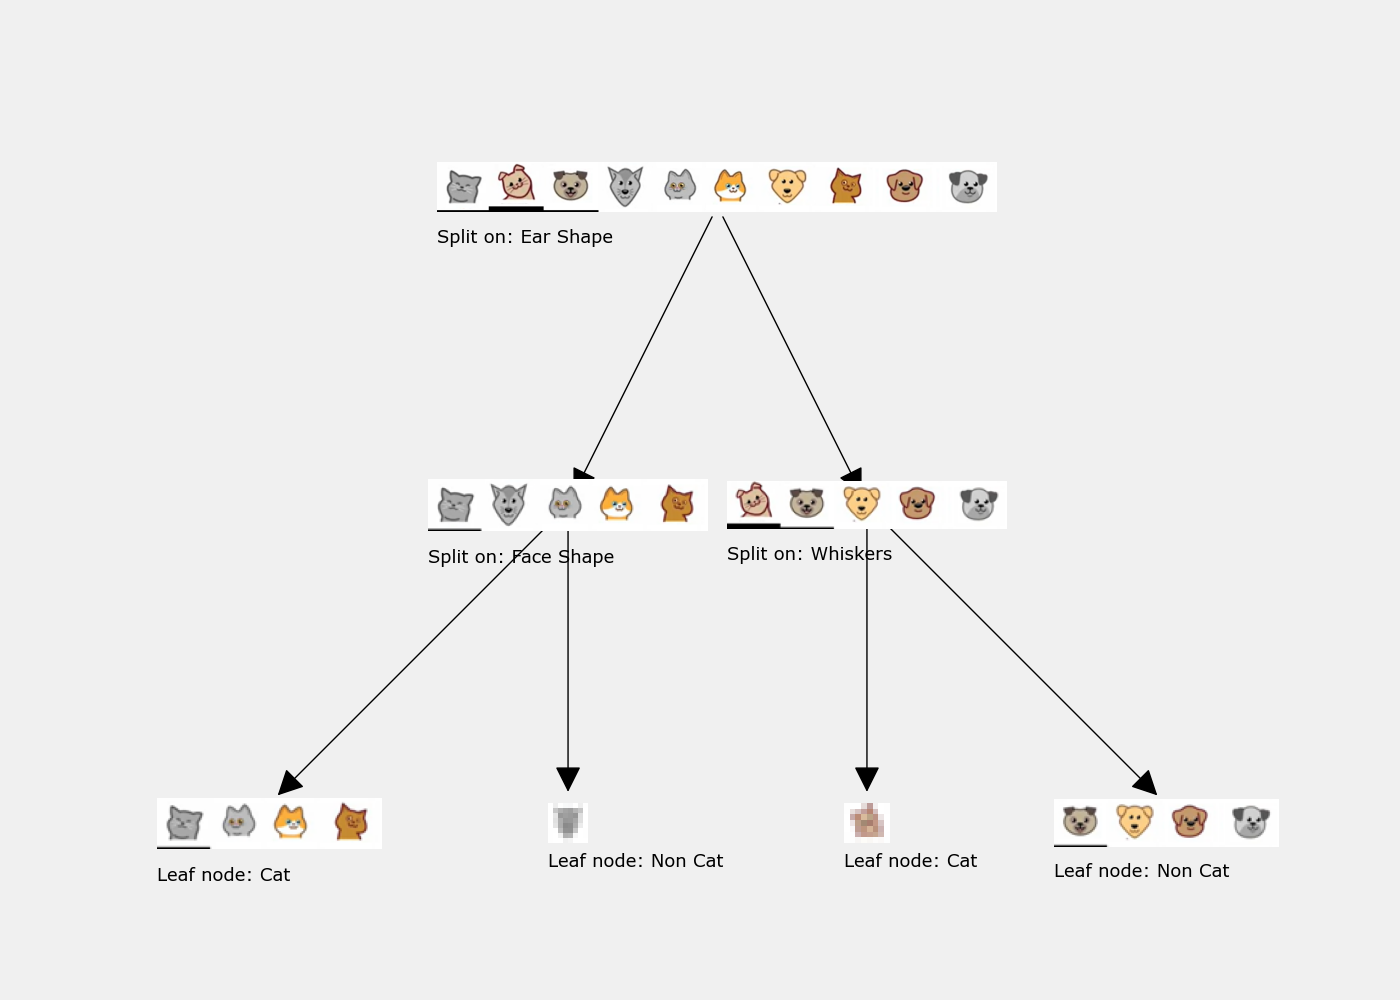

In [14]:
tree = []
build_tree_recursive(X_train, y_train, [0,1,2,3,4,5,6,7,8,9], "Root", max_depth=2, current_depth=0, tree=tree)
generate_tree_viz([0,1,2,3,4,5,6,7,8,9], y_train, tree)

# **Tree Ensemble**

In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')

RANDOM_STATE = 55

In [3]:
# Load the dataset using pandas
df = pd.read_csv("heart.csv")

In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
cat_variables = ['Sex',
                 'ChestPainType',
                 'RestingECG',
                 'ExerciseAngina',
                 'ST_Slope'
                 ]

In [6]:
# This will replace the columns with the one-hot encoded ones and keep the columns outside 'columns' argument as it is.
df = pd.get_dummies(data = df,
                    prefix = cat_variables,
                    columns = cat_variables)

In [7]:
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,False,True,False,True,False,False,False,True,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,True,False,False,False,True,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,False,True,False,True,False,False,False,False,True,True,False,False,False,True
3,48,138,214,0,108,1.5,1,True,False,True,False,False,False,False,True,False,False,True,False,True,False
4,54,150,195,0,122,0.0,0,False,True,False,False,True,False,False,True,False,True,False,False,False,True


In [8]:
features = [x for x in df.columns if x not in 'HeartDisease'] ## Removing our target variable

In [9]:
print(len(features))

20


In [10]:
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
    Split arrays or matrices into random train and test subsets.
    
    Quick utility that wraps input validation,
    ``next(ShuffleSplit().split(X, y))``, and application to input data
    into a single call for splitting (and optionally subsampling) data into a
    one-liner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to

In [11]:
X_train, X_val, y_train, y_val = train_test_split(df[features], df['HeartDisease'], train_size=0.8, random_state=RANDOM_STATE)

# We will keep the shuffle = True since our dataset has not any time dependency.

In [12]:
print(f'train samples: {len(X_train)}')
print(f'validation samples: {len(X_val)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

train samples: 734
validation samples: 184
target proportion: 0.5518


In [13]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700] ##If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.

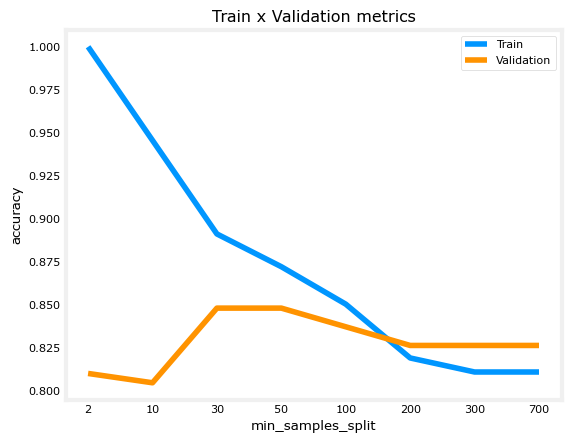

In [14]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    # you can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(min_samples_split=min_samples_split,
                                   random_state=RANDOM_STATE).fit(X_train, y_train)
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train', 'Validation'])

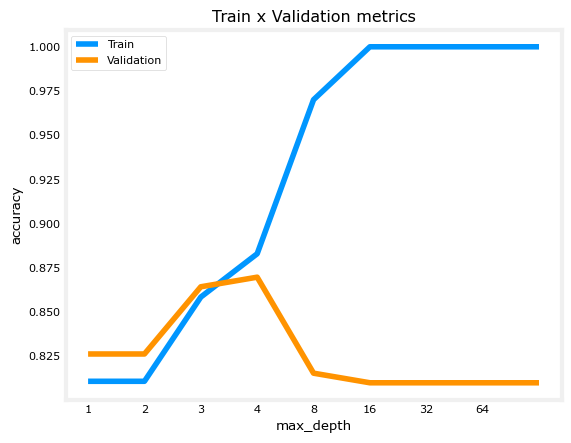

In [15]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # you can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(max_depth=max_depth,
                                   random_state=RANDOM_STATE).fit(X_train, y_train)
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train', 'Validation'])

In [16]:
decision_tree_model = DecisionTreeClassifier(max_depth=4, min_samples_split=50, random_state=RANDOM_STATE).fit(X_train, y_train)

In [17]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train), y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_val), y_val):.4f}")

Metrics train:
	Accuracy score: 0.8665
Metrics validation:
	Accuracy score: 0.8696


In [18]:
min_samples_split_list = [2, 10, 30, 50, 100, 200, 300, 700]
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10, 50, 100, 500]

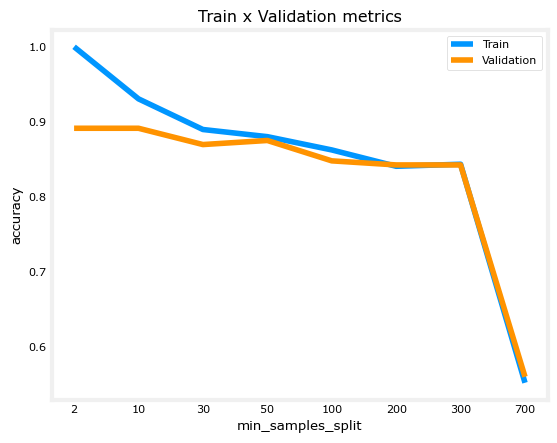

In [19]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    # you can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(min_samples_split=min_samples_split,
                                   random_state=RANDOM_STATE).fit(X_train, y_train)
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train', 'Validation'])

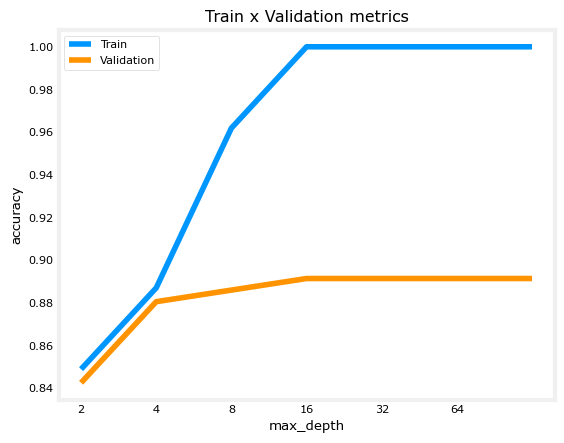

In [20]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # you can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(max_depth=max_depth,
                                   random_state=RANDOM_STATE).fit(X_train, y_train)
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train', 'Validation'])

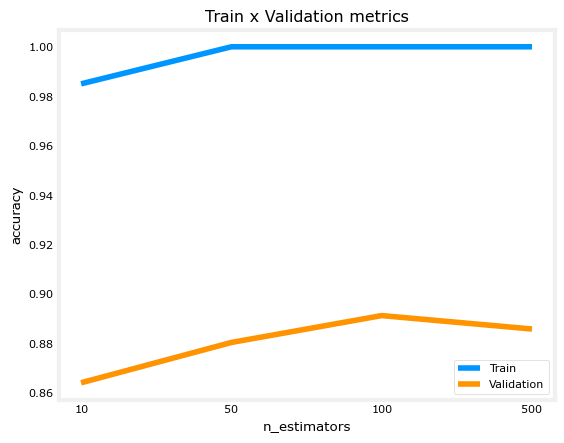

In [21]:
accuracy_list_train = []
accuracy_list_val = []
for n_estimators in n_estimators_list:
    # you can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   random_state=RANDOM_STATE).fit(X_train, y_train)
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks=range(len(n_estimators_list)), labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train', 'Validation'])

In [22]:
random_forest_model = RandomForestClassifier(n_estimators=100,
                                             max_depth=16,
                                             min_samples_split=10).fit(X_train, y_train)

In [23]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_train), y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9332
Metrics test:
	Accuracy score: 0.9076


In [24]:
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval

In [25]:
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

In [27]:
xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.1, verbosity=1,random_state=RANDOM_STATE, early_stopping_rounds=10)
xgb_model.fit(X_train_fit, y_train_fit, eval_set=[(X_train_eval,y_train_eval)])

[0]	validation_0-logloss:0.63302
[1]	validation_0-logloss:0.59554
[2]	validation_0-logloss:0.56614
[3]	validation_0-logloss:0.54187
[4]	validation_0-logloss:0.52349
[5]	validation_0-logloss:0.50611
[6]	validation_0-logloss:0.49373
[7]	validation_0-logloss:0.48366
[8]	validation_0-logloss:0.47323
[9]	validation_0-logloss:0.46538
[10]	validation_0-logloss:0.46000
[11]	validation_0-logloss:0.45621
[12]	validation_0-logloss:0.45483
[13]	validation_0-logloss:0.44975
[14]	validation_0-logloss:0.44495
[15]	validation_0-logloss:0.44073
[16]	validation_0-logloss:0.44078
[17]	validation_0-logloss:0.43936
[18]	validation_0-logloss:0.44206
[19]	validation_0-logloss:0.44536
[20]	validation_0-logloss:0.44322
[21]	validation_0-logloss:0.44310
[22]	validation_0-logloss:0.44419
[23]	validation_0-logloss:0.44797
[24]	validation_0-logloss:0.44843
[25]	validation_0-logloss:0.45337
[26]	validation_0-logloss:0.45206
[27]	validation_0-logloss:0.45435


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=55, ...)

In [28]:
xgb_model.best_iteration

17

In [29]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9319
Metrics test:
	Accuracy score: 0.8533


In [1]:
import tensorflow as tf
# print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.13.1


SyntaxError: invalid syntax (5832464.py, line 1)